In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import j1
from math import sqrt
from PIL import Image
import os
import tensorflow as tf
import pickle
from itertools import product
import pylab
%matplotlib inline

In [2]:
tf.config.experimental.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [3]:
np.set_printoptions(suppress=True, precision=5)

$$I(x,y) = p_1 \cdot \left(a_1 \cdot b_1 \cdot \frac{J_1(\frac{k}{z}\sqrt{a_1^2x^2 + b_1^2y^2})}{\frac{k}{z}\sqrt{a_1^2x^2 + b_1^2y^2}}\right)^2 + p_2 \cdot \left(a_2 \cdot b_2 \cdot \frac{J_1(\frac{k}{z}\sqrt{a_2^2x^2 + b_2^2y^2})}{\frac{k}{z}\sqrt{a_2^2x^2 + b_2^2y^2}}\right)^2 $$

## Data generation

In [4]:
def generateParameters(elongation=4, badcellperc=0.3):
    r = 4
    
    eps2 = elongation
    p1 = badcellperc
    p2 = 1 - p1
    
    a1 = r
    b1 = r
    
    a2 = (eps2 ** 0.5) * r
    b2 = r / (eps2 ** 0.5)
    
    return [p1, a1, b1, p2, a2, b2]

In [5]:
class DiffractionPatternGenerator:
    def __init__(self, 
                 z=65_000,
                 lmbda=0.63,
                 max_angle_degree=15,
                 n_points=1000):
        self.z = tf.Variable(z, dtype=float)
        self.lmbda = tf.Variable(lmbda, dtype=float)
        self.k = tf.Variable(2 *np.pi/lmbda, dtype=float)
        
        max_angle_degree = 15;
        max_angle = max_angle_degree * np.pi / 180;

        x_max = z * np.tan(max_angle)
        y_max = z * np.tan(max_angle)

        n_points = 1000 # resolution of our diffraction pattern picture in both axis
        x_ar = np.linspace(-x_max, x_max, n_points)
        y_ar = np.linspace(-y_max, y_max, n_points)
        
        buf = np.meshgrid(y_ar[:y_ar.shape[0]], x_ar[:x_ar.shape[0]])
        self.x_data = tf.Variable(buf[1], dtype=float)
        self.y_data = tf.Variable(buf[0], dtype=float)
        
        self.p1 = tf.Variable(0, dtype=float)
        self.a1 = tf.Variable(0, dtype=float)
        self.b1 = tf.Variable(0, dtype=float)
        self.p2 = tf.Variable(0, dtype=float)
        self.a2 = tf.Variable(0, dtype=float)
        self.b2 = tf.Variable(0, dtype=float)
        self.q1 = tf.Variable(0,shape=tf.TensorShape(None), dtype=float)
        self.q2 = tf.Variable(0,shape=tf.TensorShape(None), dtype=float)
        
    def I_tf(self):
        self.q1.assign(self.k/self.z*tf.sqrt(tf.square(self.a1 * self.x_data) + tf.square(self.b1 * self.y_data)))
        self.q2.assign(self.k/self.z*tf.sqrt(tf.square(self.a2 * self.x_data) + tf.square(self.b2 * self.y_data)))
        
        return self.p1 * tf.square(self.a1 * self.b1 * tf.math.special.bessel_j1(self.q1) / self.q1) +\
               self.p2 * tf.square(self.a2 * self.b2 * tf.math.special.bessel_j1(self.q2) / self.q2)
    
    def getPattern(self, params):
        self.p1.assign(params[0])
        self.a1.assign(params[1])
        self.b1.assign(params[2])
        self.p2.assign(params[3])
        self.a2.assign(params[4])
        self.b2.assign(params[5])
        
        return self.I_tf()

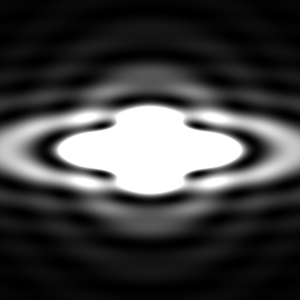

In [6]:
generator = DiffractionPatternGenerator()
im = Image.fromarray(generator.getPattern(generateParameters()).numpy() * 255)
im.convert("L").resize((300, 300))

## Metropolis-Hastings

In [7]:
#In this symmetrical case we can use only 1/4 of data
generator = DiffractionPatternGenerator()
I_data = generator.getPattern(generateParameters())

In [8]:
def transition_model(params, it, lr):
    p1, a1, b1, a2, b2, sigma = params
    scale = lr# * 10 ** -(it // 1000)
    p1_new = np.random.normal(loc=p1, scale=scale)
    
    a1_new = np.random.normal(loc=a1, scale=scale)
    b1_new = np.random.normal(loc=b1, scale=scale)
    
    a2_new = np.random.normal(loc=a2, scale=scale)
    b2_new = np.random.normal(loc=b2, scale=scale)
    sigma_new  = np.random.normal(loc=sigma, scale=scale)
    
    return np.array([p1_new, a1_new, b1_new, a2_new, b2_new, sigma_new])

In [9]:
#what we already know about parameters
def prior(params):
    p1, a1, b1, a2, b2, sigma = params
    if  sigma > 0 \
    and a1 > 0 \
    and b1 > 0 \
    and a2 > 0 \
    and b2 > 0 \
    and 0 < p1 <= 0.5\
    and  0.95 < a1 / b1 < 1.05\
    and 0.95 < (a2 * b2) / (a1 * b1) < 1.05:
        return True
    return False

In [10]:
#log likelihood function
def loglike(params, ii):
    p1, a1, b1, a2, b2, sigma = params
    params_tf = [p1, a1, b1, 1-p1, a2, b2]
    lp = prior(params)
    if not lp:
        return -np.inf
    else:
        p2 = 1 - p1
        return -tf.reduce_sum(tf.square(ii - generator.getPattern(params_tf) )) / (tf.square(tf.Variable(sigma, dtype=float)) * 2)-ii.shape[0]*ii.shape[1]*tf.math.log(sigma*tf.sqrt(2*tf.constant(np.pi)))

$$\log{\mathcal{L}} 
= \log{\prod\limits_{i, j=1}^N{f(I_{ij}|x_i, y_j,\lambda, z, \theta)}}=
-N^2\cdot\log{\sigma\sqrt{2\pi}} - \sum_{i=1}^N\sum_{j=1}^N{\frac{(I_{ij} - I(x_i, y_j, \lambda, z, \theta))^2}{2\sigma^2}}$$

In [11]:
#Decides whether new params better or not
def acceptance(params, params_new):
    if params_new > params:
        return True
    else:
        #return False
        accept=np.random.uniform(0,1)
        return (accept < (np.exp(params_new-params)))

In [12]:
def metropolis_hastings(likelihood, prior, transition_model, param_init, num_iterations, data, acceptance_rule, lr):
    params = param_init
    accepted = []
    rejected = []   
    all_params = []
    logs = []
    params_lik = None
    states = []
    for i in range(num_iterations):
        states.append(params)
        params_new =  transition_model(params, i, lr)    
        if params_lik == None:
            params_lik = likelihood(params, *data)
        params_new_lik = likelihood(params_new, *data)
        logs.append(params_new_lik)
        if (acceptance_rule(params_lik,params_new_lik)):            
            params = params_new
            params_lik = params_new_lik
            accepted.append(params_new)  
        all_params.append(params_new)
    return np.array(accepted), np.array(states), np.array(all_params)

In [13]:
NUM_ITERATIONS = 10_000
INIT_APPROX = [0.5, 1.0, 1.0, 1.0, 1.0 , 0.1]
LEARNING_RATE  = tf.constant(0.05)

In [14]:
accepted, states, all_params = metropolis_hastings(loglike,
                                         prior,
                                         transition_model,
                                         INIT_APPROX, 
                                         NUM_ITERATIONS,
                                         [I_data],
                                         acceptance, LEARNING_RATE)


In [15]:
accepted[-1]

array([0.28662, 3.9808 , 4.06351, 7.95654, 1.99998, 0.03321])

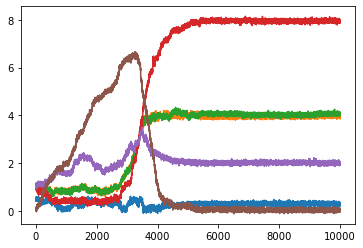

In [16]:
plt.plot(all_params)

In [17]:
generator_grid = {
    "elongation" : list(np.arange(1, 26, 1.)),
    "badcellperc": list(np.arange(0.05, 0.5, 0.025))
}

In [18]:
NUM_ITERATIONS = 4000
INIT_APPROX = [0.5, 1.0, 1.0, 1.0, 1.0 , 0.1]
LEARNING_RATE  = tf.constant(0.05)
def get_grid_results(grid):
    generator = DiffractionPatternGenerator()
    keys, values = zip(*grid.items())
    res = []
    for g in tqdm(product(*values)):
        d = dict(zip(keys, g))
        true_params = generateParameters(**d)
        I_data = generator.getPattern(true_params)
        accepted, states, all_params = metropolis_hastings(loglike,
                                         prior,
                                         transition_model,
                                         INIT_APPROX, 
                                         NUM_ITERATIONS,
                                         [I_data],
                                         acceptance, LEARNING_RATE)
        res.append((true_params, accepted, states, all_params))
    return res

In [19]:
res = get_grid_results(generator_grid)

450it [1:18:52, 10.52s/it]


In [20]:
pickle.dump(res, open("grid_res.pickle", 'wb'))

In [21]:
res = pickle.load(open("grid_res.pickle", "rb"))

In [22]:
res_mse = list(map(lambda x: ((x[0][:3]+x[0][4:] - x[1][-1][:-1]) ** 2).mean(), res))

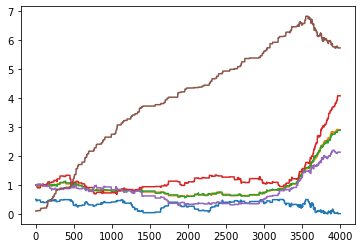

In [49]:
plt.plot(res[435][2])

In [25]:
res_z = np.reshape(res_mse, (len(generator_grid['elongation']), len(generator_grid['badcellperc'])))

In [41]:
xx,yy = pylab.meshgrid(generator_grid['badcellperc'], generator_grid['elongation'])


In [42]:
yy

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.],
       [ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.],
       [ 3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
         3.,  3.,  3.,  3.,  3.],
       [ 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
         4.,  4.,  4.,  4.,  4.],
       [ 5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
         5.,  5.,  5.,  5.,  5.],
       [ 6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
         6.,  6.,  6.,  6.,  6.],
       [ 7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
         7.,  7.,  7.,  7.,  7.],
       [ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
         8.,  8.,  8.,  8.,  8.],
       [ 9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
         9.,  9.,  9.,  9.,  9.],
       [10., 10., 10., 10., 10., 10.,

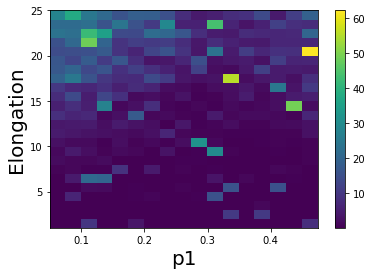

In [55]:
pylab.pcolor(xx, yy, res_z)
pylab.colorbar()
pylab.xlabel("p1", fontsize=20)
pylab.ylabel("Elongation", fontsize=20)